# Empirical Illustration of Incompatible Fairness Definitions in Risk Scoring

In [1]:
# Imports : pandas, numpy, matplotlib, scikit-learn

for pkg in ["pandas","numpy","matplotlib","scikit-learn"]:
    try:
        __import__(pkg)
        print(f"{pkg} Already installed")
    except ImportError:
        print(f"{pkg} Not found. Installation in progress...")
        !pip install {pkg}

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pandas Already installed
numpy Already installed
matplotlib Already installed
scikit-learn Not found. Installation in progress...


## 1) Illustration of the Incompatibility Using the COMPAS Dataset

### Loading the COMPAS dataset

This cell loads the **COMPAS two-year recidivism** dataset made available by ProPublica.  
This dataset contains individual-level information (demographic characteristics, COMPAS scores, observed recidivism) for people assessed by the COMPAS system.

The file is publicly hosted on GitHub and can be loaded directly via its URL.


In [3]:
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df = pd.read_csv(url)

df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


### Definition of the experimental setting and correspondence with the theoretical notation

In *Inherent Trade-Offs in the Fair Determination of Risk Scores* (Kleinberg et al., 2016),  
the authors formalize the problem using three fundamental variables:

- \( Y \): binary outcome variable representing the event to be predicted,
- \( S \): risk score assigned to an individual,
- \( G \): group variable defining a partition of the population.

In the empirical analysis based on the **COMPAS** dataset, these variables
correspond to the following columns:

- **\( Y \)** (*Outcome*)  
  → **two_year_recid**  
  Binary variable indicating whether an individual reoffended within two years following the assessment  
  (\( Y = 1 \) in case of recidivism, \( Y = 0 \) otherwise).

- **\( S \)** (*Risk score*)  
  → **decile_score**  
  COMPAS score discretized into 10 deciles, where higher values indicate a higher risk
  of recidivism.

- **\( G \)** (*Group membership*)  
  → **race**  
  Categorical variable representing racial group membership.  
  The analysis focuses exclusively on the *African-American* and *Caucasian* groups.



In [4]:
# Number of observations before filtering

print("Total number of observations :", len(df))

# Label Y : Two-year recidivism
label_col = "two_year_recid"

# Score S : score COMPAS
score_col = "decile_score"

# Groupe G : race (We keep only African-American / Caucasian)
group_col = "race"
groups_of_interest = ["African-American", "Caucasian"]

# Group filtering
df = df[df[group_col].isin(groups_of_interest)]

# Removal of missing values
df = df.dropna(subset=[label_col, score_col, group_col])

print("Number of observations after filtering :", len(df))

Total number of observations : 7214
Number of observations after filtering : 6150


### Verification of base rates and validity of the theorem’s assumption

This cell computes the recidivism base rates for each group, i.e.:  
$ P(Y = 1 \mid G) $, which is the central condition of the impossibility theorem of Kleinberg et al. (2016).

Base rates measure the average probability of observed recidivism within each group,
independently of the risk score.  
The theorem states that if these base rates differ across groups, then it is impossible to
simultaneously satisfy certain fairness definitions (calibration, balance for the positive and negative classes).

#### Interpretation of the results

An explicit comparison of base rates across groups makes it possible to determine whether
the key assumption of the theorem is satisfied:

$$ 
P(Y=1 \mid G=\text{Black}) \neq P(Y=1 \mid G=\text{White})
$$  

If the base rates are different, then the fairness conditions cannot be satisfied simultaneously.  
This step therefore formally establishes the setting in which conflicts between fairness definitions may arise.



In [5]:
# Verification of base rates (theorem condition)

base_rates = (
    df.groupby(group_col)[label_col]
      .mean()
      .rename("Base rate P(Y=1 | G)")
)

counts = df[group_col].value_counts()

print("\nBase rate by group :")
print(base_rates)

# Difference in base rates

br_black = base_rates["African-American"]
br_white = base_rates["Caucasian"]

print("\nBase rate difference (Black - White) :",
      br_black - br_white)

if br_black != br_white:
    print("\nBase rates differ: Kleinberg et al.'s theorem applies.")
else:
    print("\nBase rates are equal: the theorem does not apply.")



Base rate by group :
race
African-American    0.514340
Caucasian           0.393643
Name: Base rate P(Y=1 | G), dtype: float64

Base rate difference (Black - White) : 0.12069679505498576

Base rates differ: Kleinberg et al.'s theorem applies.


### Computation of calibration by bin for each group

This cell evaluates the calibration of the COMPAS score within each group.  
Calibration is a central concept in the paper by Kleinberg et al.: a score is *calibrated within groups* if, for a given score \( S = s \), the probability of recidivism is the same for all individuals with that score, within each group \( G \):

$$
P(Y=1 \mid S=s, G=g) = s
.$$


In [6]:
label_col = "two_year_recid"
score_col = "decile_score"
group_col = "race"
groups = ["African-American", "Caucasian"]

# Computation of calibration by bin

calibration_table = (
    df.groupby([group_col, score_col])[label_col]
      .agg(
          empirical_rate="mean",
          count="size"
      )
      .reset_index()
)

# "Theoretical" score associated with the bin (normalized between 0 and 1)
calibration_table["score_value"] = calibration_table[score_col] / 10.0

print("\nCalibration table by group and bin:")
print(calibration_table.head(20))



Calibration table by group and bin:
                race  decile_score  empirical_rate  count  score_value
0   African-American             1        0.228643    398          0.1
1   African-American             2        0.302799    393          0.2
2   African-American             3        0.419075    346          0.3
3   African-American             4        0.459740    385          0.4
4   African-American             5        0.482192    365          0.5
5   African-American             6        0.559896    384          0.6
6   African-American             7        0.592500    400          0.7
7   African-American             8        0.682451    359          0.8
8   African-American             9        0.707895    380          0.9
9   African-American            10        0.793706    286          1.0
10         Caucasian             1        0.208517    681          0.1
11         Caucasian             2        0.313019    361          0.2
12         Caucasian             3      

### Visualization of calibration by group

Ideally, for a score \( S = s \) and a group \( G = g \), calibration is defined as:

$$
P(Y=1 \mid S=s, G=g) = s
$$

However, in our COMPAS dataset, the score \( S \) is discrete, in deciles (1 to 10). The normalized “theoretical score” we defined (**score_value = decile_score / 10**) does not exactly correspond to the true recidivism probabilities within each bin. As a result, it is impossible to strictly test \( P(Y=1 \mid S=s, G=g) = s \). We therefore test a comparative version across groups instead:

$$
P(Y=1 \mid S=s, G=\text{African-American}) \approx P(Y=1 \mid S=s, G=\text{Caucasian})
$$

This allows us to assess whether, for the same score bin, the empirical probability of recidivism is similar across groups.



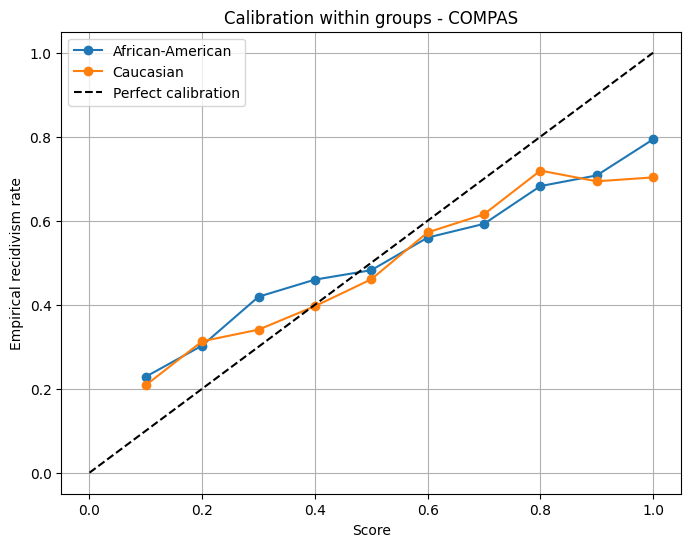

In [7]:
# List of groups
groups = calibration_table[group_col].unique()

plt.figure(figsize=(8,6))

for g in groups:
    sub = calibration_table[calibration_table[group_col] == g]
    plt.plot(sub["score_value"], sub["empirical_rate"], marker='o', label=g)

# Diagonal line for reference (score_value = empirical rate if perfectly calibrated))
plt.plot([0,1], [0,1], 'k--', label="Perfect calibration")

plt.xlabel("Score")
plt.ylabel("Empirical recidivism rate")
plt.title("Calibration within groups - COMPAS")
plt.legend()
plt.grid(True)
plt.show()


### Conclusion on the calibration of the COMPAS score

The empirical analysis of recidivism rates by score bin shows that, for the **African-American** and **Caucasian** groups, the COMPAS score is approximately *calibrated within groups*:

- Empirical recidivism rates increase monotonically with the score for each group.
- The observed differences between the two groups are relatively small.


### Verification of the fairness conditions “balance for the positive class” and “balance for the negative class”

After evaluating the calibration of the COMPAS score, we test whether the model satisfies the fairness conditions **balance for the positive class** and **balance for the negative class**:

- **Balance for the positive class**: the average scores of individuals who reoffended (\( Y = 1 \)) should be equal across groups.
$$
\mathbb{E}[S \mid Y=1, G=0] \stackrel{?}{=} \mathbb{E}[S \mid Y=1, G=1]
$$

- **Balance for the negative class**: the average scores of individuals who did not reoffend (\( Y = 0 \)) should be equal across groups.
$$
\mathbb{E}[S \mid Y=0, G=0] \stackrel{?}{=} \mathbb{E}[S \mid Y=0, G=1]
$$

If base rates differ and calibration is satisfied, these two conditions cannot be simultaneously satisfied.


In [8]:
# Computation of average scores by group for each Y class

positive_scores = df[df[label_col] == 1].groupby(group_col)[score_col].mean()
negative_scores = df[df[label_col] == 0].groupby(group_col)[score_col].mean()

print("Average scores for the positive class (Y=1) :")
print(positive_scores)

print("\nAverage scores for the negative class (Y=0) :")
print(negative_scores)


Average scores for the positive class (Y=1) :
race
African-American    6.287217
Caucasian           4.817805
Name: decile_score, dtype: float64

Average scores for the negative class (Y=0) :
race
African-American    4.396100
Caucasian           3.032258
Name: decile_score, dtype: float64


### Conclusion on “balance for the positive/negative class”

The analysis of average scores by group shows that:

- **Positive class (Y = 1)**: African-American individuals have an average score of **6.29**, while Caucasian individuals have an average score of **4.82**.  
- **Negative class (Y = 0)**: African-American individuals have an average score of **4.40**, while Caucasian individuals have an average score of **3.03**.

These results indicate that average scores differ across groups, meaning that **balance for the positive class** and **balance for the negative class** are not satisfied, thereby illustrating the impossibility theorem.

It is important to note that these calculations are approximate, since the COMPAS score is discrete in deciles rather than continuous. Despite this approximation, the results clearly illustrate the empirical trade-off predicted by the impossibility theorem of Kleinberg et al.: when base rates differ and calibration is satisfied, it is impossible to satisfy balance conditions across groups.

The observed differences suggest that the COMPAS scoring model appears biased and unfair toward African-American individuals, as for the same outcome \( Y \), they receive higher scores on average than Caucasian individuals.

However, this is also a fundamental mathematical limitation: because the base rates $ P(Y=1 \mid G) $ differ, if the model is well calibrated within groups, it is mathematically impossible to simultaneously satisfy fairness definitions based on balance for the positive and negative classes. This is precisely what the impossibility theorem of Kleinberg et al. states and formalizes.



## 2) Illustration using logistic regression with the COMPAS dataset

### Logistic Regression Model to Generate Risk Scores 

We train a logistic regression to predict 2-year recidivism (**two_year_recid**) using the following features:

**Features used**:

- **age** : Age of the individual  
- **priors_count.1** : Number of prior offenses  
- **c_charge_degree** : Charge degree (misdemeanor/felony)  
- **age_cat** : Age category   

The output $S = \hat{P}(Y=1 \mid X)$ will serve as a continuous risk score, suitable for illustrating calibration and fairness trade-offs.


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


# Features to use (excluding sex)
features = ["age", "priors_count.1", "c_charge_degree", "age_cat"]
target = "two_year_recid"

# Prepare the DataFrame for modeling
df_model = df[features + [target, "race"]].copy()

# Encode categorical variables as dummies
categorical_vars = ["c_charge_degree", "age_cat"]
df_model = pd.get_dummies(df_model, columns=categorical_vars, drop_first=True)

# Separate X and y
X = df_model.drop([target, "race"], axis=1)
y = df_model[target]

# Standardize numeric features
numeric_vars = ["age", "priors_count.1"]
scaler = StandardScaler()
X[numeric_vars] = scaler.fit_transform(X[numeric_vars])

# Train logistic regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X, y)

# Predicted probabilities as continuous risk scores
df["logreg_score"] = logreg.predict_proba(X)[:, 1]

print("First 10 predicted risk scores:")
print(df[["logreg_score"]].head(10))


First 10 predicted risk scores:
    logreg_score
1       0.319835
2       0.657725
3       0.557572
6       0.749696
8       0.239989
9       0.582179
10      0.400570
11      0.598409
12      0.258778
13      0.248624


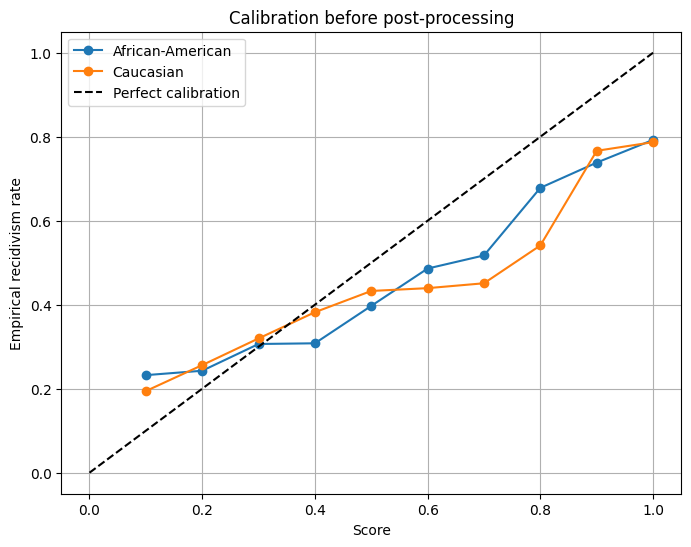

In [11]:
# Score binning to visualize calibration
df["score_bin"] = pd.qcut(df["logreg_score"], 10, labels=False, duplicates='drop') + 1

# Calibration table
calibration_table = (
    df.groupby(["race", "score_bin"])["two_year_recid"]
      .agg(empirical_rate="mean", count="size")
      .reset_index()
)

# "Theoretical" score associated with the bin (normalized between 0 and 1)
calibration_table["score_value"] = calibration_table["score_bin"] / 10.0

# Visualization
plt.figure(figsize=(8,6))
for g in calibration_table["race"].unique():
    sub = calibration_table[calibration_table["race"] == g]
    plt.plot(sub["score_value"], sub["empirical_rate"], marker='o', label=g)

# Diagonal for reference
plt.plot([0,1], [0,1], 'k--', label="Perfect calibration")
plt.xlabel("Score")
plt.ylabel("Empirical recidivism rate")
plt.title("Calibration before post-processing")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# Conditional means by group for Y=1 and Y=0
positive_scores = df[df["two_year_recid"] == 1].groupby("race")["logreg_score"].mean()
negative_scores = df[df["two_year_recid"] == 0].groupby("race")["logreg_score"].mean()

print("Average scores for the positive class (Y=1):")
print(positive_scores)

print("\nAverage scores for the negative class (Y=0):")
print(negative_scores)


Average scores for the positive class (Y=1):
race
African-American    0.576824
Caucasian           0.470780
Name: logreg_score, dtype: float64

Average scores for the negative class (Y=0):
race
African-American    0.441078
Caucasian           0.352244
Name: logreg_score, dtype: float64


Once again, the fairness conditions corresponding to **balance for the positive class** and **balance for the negative class** are not satisfied. We now attempt to enforce these conditions artificially through post-processing in order to illustrate the impossibility theorem.


### Linear Transformations Applied to Enforce Balance

To ensure **balance for the positive and negative classes**, we applied simple linear shifts to the predicted risk scores by group and class.  

#### Compute target means
For each class \(Y=1\) and \(Y=0\), we computed the target mean as the average of the two groups:

$$
\text{target\_mean\_pos} = \frac{\text{mean(African-American, Y=1)} + \text{mean(Caucasian, Y=1)}}{2}
$$

$$
\text{target\_mean\_neg} = \frac{\text{mean(African-American, Y=0)} + \text{mean(Caucasian, Y=0)}}{2}
$$

#### Apply linear shifts
For each individual, we applied a shift depending on their group and class:

$$
S' = S + (\text{target\_mean} - \text{current\_group\_mean})
$$

- $S$ : original predicted score  
- $S'$ : adjusted score  
- $\text{target\_mean}$ : target mean for the class (positive or negative)  
- $\text{current\_group\_mean}$ : original mean for the individual’s group and class  

#### Effect
- The mean score per group and class is now equal to the target mean 
- The relative ranking of scores within each group and class is preserved 
- This ensures perfect balance for the positive and negative classes




In [13]:
# Verification of fairness conditions: balance for the positive class and balance for the negative class

df_adjusted = df.copy()

# Current averages
mean_pos = df_adjusted[df_adjusted["two_year_recid"] == 1].groupby("race")["logreg_score"].mean()
mean_neg = df_adjusted[df_adjusted["two_year_recid"] == 0].groupby("race")["logreg_score"].mean()

# Target averages
target_mean_pos = mean_pos.mean()
target_mean_neg = mean_neg.mean()

# Adjustement for Y=1
for race in df_adjusted["race"].unique():
    mask = (df_adjusted["two_year_recid"] == 1) & (df_adjusted["race"] == race)
    df_adjusted.loc[mask, "logreg_score_balanced"] = (
        df_adjusted.loc[mask, "logreg_score"] + (target_mean_pos - mean_pos[race])
    )

# Adjustement for Y=0
for race in df_adjusted["race"].unique():
    mask = (df_adjusted["two_year_recid"] == 0) & (df_adjusted["race"] == race)
    df_adjusted.loc[mask, "logreg_score_balanced"] = (
        df_adjusted.loc[mask, "logreg_score"] + (target_mean_neg - mean_neg[race])
    )

# Verification
balanced_pos = df_adjusted[df_adjusted["two_year_recid"] == 1].groupby("race")["logreg_score_balanced"].mean()
balanced_neg = df_adjusted[df_adjusted["two_year_recid"] == 0].groupby("race")["logreg_score_balanced"].mean()

print("Balanced scores for positive class (Y=1):")
print(balanced_pos)

print("\nBalanced scores for negative class (Y=0):")
print(balanced_neg)


Balanced scores for positive class (Y=1):
race
African-American    0.523802
Caucasian           0.523802
Name: logreg_score_balanced, dtype: float64

Balanced scores for negative class (Y=0):
race
African-American    0.396661
Caucasian           0.396661
Name: logreg_score_balanced, dtype: float64


### Conclusion on post-processing and the trade-off between different fairness definitions

The post-processing applied to enforce balance for the positive and negative class allows two out of three fairness definitions to be satisfied.

However, this transformation comes at a significant cost:

- The model’s calibration is degraded, particularly for scores around 0.8, as shown in the graph below.  
- The overall predictive power of the model may also be affected, since scores have been artificially adjusted to balance the groups.

This situation directly illustrates the **impossibility theorem of Kleinberg et al. (2016)**:  
When base rates $ P(Y=1 \mid G) $ differ between groups, it is mathematically impossible to construct a score that is both calibrated and satisfies all fairness definitions simultaneously.

In summary, post-processing is a tool to achieve certain fairness definitions, but it cannot guarantee all fairness conditions, as this is a mathematical impossibility.


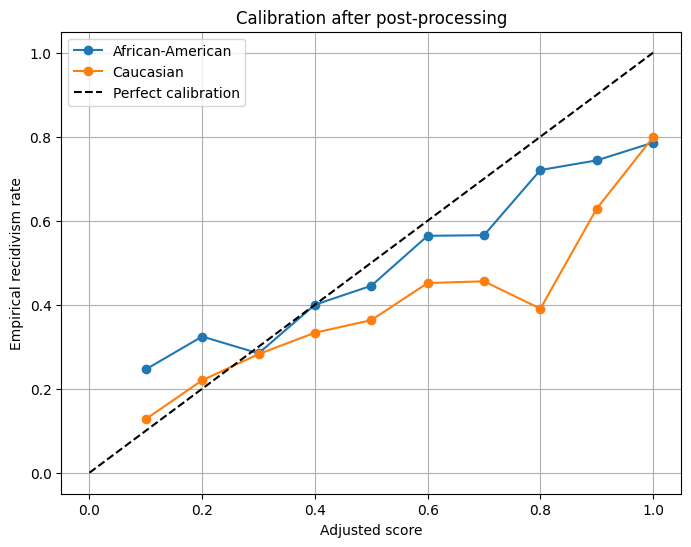

In [ ]:
# Binning of the adjusted score to visualize calibration
df_adjusted["score_bin"] = pd.qcut(df_adjusted["logreg_score_balanced"], 10, labels=False, duplicates='drop') + 1

# Calibration table
calibration_table = (
    df_adjusted.groupby(["race", "score_bin"])["two_year_recid"]
        .agg(empirical_rate="mean", count="size")
        .reset_index()
)

# "Theoretical" score associated with the bin (normalized between 0 and 1)
calibration_table["score_value"] = calibration_table["score_bin"] / 10.0

# Visualization
plt.figure(figsize=(8,6))
for g in calibration_table["race"].unique():
    sub = calibration_table[calibration_table["race"] == g]
    plt.plot(sub["score_value"], sub["empirical_rate"], marker='o', label=g)

# Diagonal for reference
plt.plot([0,1], [0,1], 'k--', label="Perfect calibration")
plt.xlabel("Adjusted score")
plt.ylabel("Empirical recidivism rate")
plt.title("Calibration after post-processing")
plt.legend()
plt.grid(True)
plt.show()
